# Dynamic quantization
Given a latent variable (such as line orientation angle in visual cortex V1 region), each neuron may become selective to a certain value of the latent variable. The number of neurons that prefer a certain line orientation are proportional to the probability of that line orientation occuring in natural scenes. The resulting distribution of neurons represents the prior probability of line orientations.

When a particular input comes in to V1, the counts of orientation preferences of active neurons represents posterior probability of line orientations because it is prior (# distribution of neurons), multiplied by likelihood (neurons made active by actual line orientation present in input).

In our model, mu should be such posterior. To compute it, we need to find prior and the likelihood will be given by previous layer.

Here we develop functions that build a sample distribution and find out ranges that admin approximately equal number of elements. The resulting ranges are wide where few inputs are present and closely spaced where input values are more numerous.

In [272]:
import numpy as np
from scipy.stats import norm
import math
import pandas as pd

def qcut_bins(values, count=10):
    assert len(values.shape) == 1, "Need 1D numpy array of values"
    assert count > 1
    _, bins = pd.qcut(values, q=count-1, retbins=True)
    return bins

def soft_digitize(values, bins):
    digits = np.digitize(values, bins)
    output = digits.astype(float)
    print(digits.dtype)
    for index, digit in enumerate(digits):
        if digit > 0 and digit < len(bins):
            val_left = bins[digit-1]
            val_right = bins[digit]
            output[index] += (values[index] - val_left) / (val_right - val_left)

    output -= 1
    output.clip(0, len(bins) - 1, out=output)
    return output

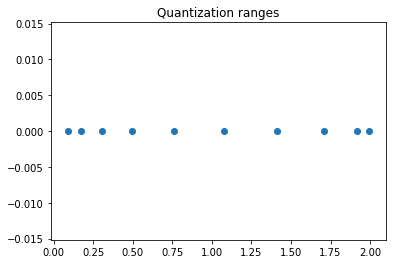

int64


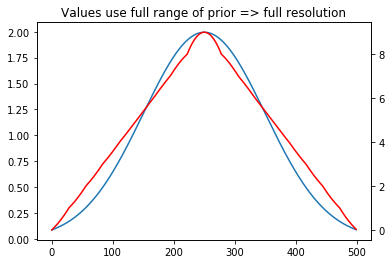

int64


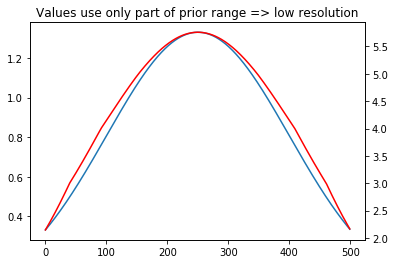

int64


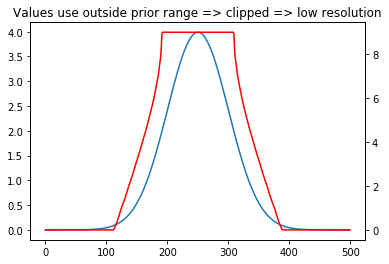

In [274]:
import matplotlib.pyplot as plt
%matplotlib inline

values = norm.pdf(np.arange(0, 1, 1.0 / 500), 0.5, 0.2)
bins = qcut_bins(values, count=10)

plt.figure()
plt.title('Quantization ranges')
plt.scatter(bins, np.zeros_like(bins))
plt.show()

fig, ax1 = plt.subplots()
plt.title('Values use full range of prior => full resolution')
ax1.plot(values)
ax2 = ax1.twinx()
ax2.plot(soft_digitize(values, bins), 'r')
plt.show()


values = norm.pdf(np.arange(0, 1, 1.0 / 500), 0.5, 0.3)
fig, ax1 = plt.subplots()
plt.title('Values use only part of prior range => low resolution')
ax1.plot(values)
ax2 = ax1.twinx()
ax2.plot(soft_digitize(values, bins), 'r')
plt.show()


values = norm.pdf(np.arange(0, 1, 1.0 / 500), 0.5, 0.1)
fig, ax1 = plt.subplots()
plt.title('Values use outside prior range => clipped => low resolution')
ax1.plot(values)
ax2 = ax1.twinx()
ax2.plot(soft_digitize(values, bins), 'r')
plt.show()




Adjusting the prior over time could present a means to adapt to changing conditions, e.g. moving from dark to brightly lit room. Such prior adjustment could be implemented physically, such as iris adjustment, or in software such as sensitivity to loudness.

Looking at the triangular shape of posterior when prior and likelihood match, I wonder if it would make inference easier by making the posterior linear.